In [2]:
import pandas as pd
import json
import config
import glob
import gzip

- for all (level 2) concepts, get related concepts
- then filter out the ones that are not part of our works set

In [3]:
with open('../works.json', 'r') as f:
    df = pd.DataFrame(json.loads(f.read()))

In [4]:
concepts = pd.json_normalize(df['concepts'].explode())

In [5]:
# only level 2 concepts with grandparent psychology
concepts_2 = concepts.copy()[concepts.level==2]

In [6]:
concepts_hierarchy = pd.read_csv('../openalex_concepts_hierarchy.csv')
# concept ids are lowercase, parent ids not
concepts_hierarchy['parent_ids'] = concepts_hierarchy['parent_ids'].str.lower()

In [7]:
psych_id = concepts_hierarchy[concepts_hierarchy.display_name=='Psychology']['openalex_id'].iloc[0]
psych_children = concepts_hierarchy[concepts_hierarchy.parent_ids.str.find(psych_id) > -1]

In [8]:
concepts_hierarchy_2 = concepts_hierarchy.copy()[concepts_hierarchy.level==2]
concepts_hierarchy_2[['parent_display_names', 'parent_ids']] = \
    concepts_hierarchy_2[['parent_display_names', 'parent_ids']].apply(lambda x: x.str.split(', '))
concepts_hierarchy_2 = concepts_hierarchy_2.explode(['parent_display_names', 'parent_ids'])

In [9]:
concepts_hierarchy_psych = concepts_hierarchy_2.copy()[concepts_hierarchy_2.parent_ids.isin(psych_children.openalex_id)]

In [10]:
concepts_2['id'] = concepts_2['id'].str.lower()
concepts_2 = concepts_2[concepts_2.id.isin(concepts_hierarchy_psych.openalex_id)]

<AxesSubplot:>

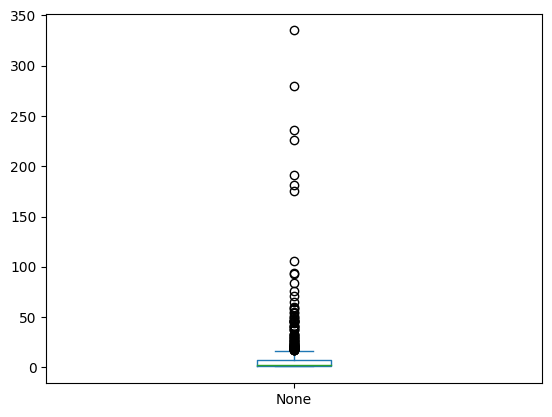

In [11]:
# count how often each concept appears in the publication set
# then filter using a cutoff
counts = concepts_2.value_counts('id')
counts.plot(kind='box')

In [12]:
# which cutoff should we pick? visualise ~ 150 nodes?
n_nodes = 50
print(len(counts))
print(n_nodes/len(counts))

860
0.05813953488372093


In [13]:
cutoff = counts.quantile(1-(n_nodes/len(counts)))
print(cutoff)

26.058139534883708


In [14]:
concepts_2['works_count'] = concepts_2.groupby(['id']).id.transform('size')

In [15]:
concepts_2 = concepts_2.drop_duplicates('id', keep='first')

In [16]:
# how many are those?
print(len(concepts_2[concepts_2.works_count > cutoff]))

50


In [17]:
concepts_2 = concepts_2[concepts_2.works_count > cutoff]

In [18]:
# save counts for plotting
counts.to_csv('../data/works_count.csv')

In [19]:
# get concepts from data snapshot
concepts_meta = []
for filename in glob.glob(f'{config.project_path}/openalex-snapshot-concepts/**/*.gz', recursive=True):
    with gzip.open(filename, 'rb') as f:
        for line in f:
            concepts_meta.append(json.loads(line))

In [20]:
len(concepts_meta)  # that's the exact amount that is stated on https://api.openalex.org/concepts

65073

In [21]:
concepts_meta_df = pd.DataFrame(concepts_meta)[['id', 'related_concepts']]
concepts_meta_df['id'] = concepts_meta_df['id'].str.lower()

In [22]:
concepts_2 = concepts_2.merge(concepts_meta_df, how='left', on='id')

In [23]:
concepts_2_relations = concepts_2.copy().explode('related_concepts').reset_index(drop=True)

In [24]:
concepts_2_relations = pd.concat([concepts_2_relations,
                                  pd.json_normalize(concepts_2_relations['related_concepts']).add_prefix('rel_')],
                                 axis=1)

In [25]:
concepts_2_relations['rel_id'] = concepts_2_relations['rel_id'].str.lower()

In [26]:
# filter out the related concepts that are not part of our set
concepts_2_relations = concepts_2_relations[concepts_2_relations['rel_id'].isin(concepts_2['id'])]

In [27]:
# level 1 concepts (parents) will be added to the graph
aux = pd.DataFrame({'id': concepts_hierarchy_psych.openalex_id,
                    'display_name': concepts_hierarchy_psych.display_name,
                    'rel_id': concepts_hierarchy_psych.parent_ids,
                    'rel_display_name': concepts_hierarchy_psych.parent_display_names,
                    'rel_level': 1})

In [28]:
concepts_2_relations = pd.concat([concepts_2_relations, aux[aux.id.isin(concepts_2_relations.id)]])

In [29]:
concepts_2_relations.to_csv('../data/concepts_relations.csv', index=False)